In [4]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.cm

from scipy import sparse
import scipy.sparse.linalg

from collections import namedtuple
import sys
import zipfile
import wget
from io import StringIO
import itertools
import time
import json
import math

import gc

import scipy.linalg as sla
from scipy import spatial
from scipy.sparse.linalg import LinearOperator


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn import metrics

import copy

import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

#import gensim

import smtplib   
from email.mime.text import MIMEText

In [5]:
gc.collect()

0

In [6]:
def send_email(text):
    smtpObj = smtplib.SMTP('smtp.mail.ru', 587)
    smtpObj.starttls()
    smtpObj.login('yura603@mail.ru','Kolom7506')
    smtpObj.sendmail('yura603@mail.ru', 'yura603@mail.ru', text)

In [7]:
def tr_svd(A, k):
    U, S, Vh = scipy.sparse.linalg.svds(A, k)
    S = np.diag(S[::-1])
    U = U[:, ::-1]
    Vh = Vh[::-1,:]
    return U, S, Vh

    
class TermHSVD:

    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, R, S, n_components):
        self.n_samples = R.shape[0]
        self.n_features = R.shape[1]
        self.n_components = n_components
        self.S = S
        self.L_s = sla.cholesky(self.S * self.alpha + np.eye(self.n_features), lower=True)
        Op = LinearOperator(R.shape, matvec=lambda x : R.dot(self.L_s.dot(x)), 
                                    rmatvec=lambda x : self.L_s.T.dot(R.transpose().dot(x)))
        self.U, self.Sigma, self.VT = tr_svd(Op, n_components)

    def fit_transform(self, R, S, n_components):
        self.fit(R, S, n_components)
        return self.U @ self.Sigma

    def transform(self, r, n_components):
        u_sigma = r @ self.L_s @ self.VT[:n_components,:].T
        return u_sigma

    
def check_hybrid_SVD(X_train, X_test, y_train, y_test, S, components_list, 
                       clfs, alpha, folding_in_flag=True, str_adding=''):
    predictions_clfs = [[] for _ in clfs]
    max_components = max(components_list)
    term_hsvd = TermHSVD(alpha)
    print(str_adding + 'fitting Hybrid SVD')
    if folding_in_flag:
        term_hsvd.fit(X_train, S, max_components)
        U_train, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
        U_test_Sigma = term_hsvd.transform(X_test, max_components)
    else:
        X = scipy.sparse.vstack([X_train, X_test])
        term_hsvd.fit(X, S, max_components)
        U, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    print(str_adding + 'fitting Hybrid SVD ended')
    U_train_Sigma = U_train @ Sigma
    for n_comps in components_list:
        print(str_adding + 'n_comps: %d' % n_comps)
        U_train_Sigma_cut = U_train_Sigma[:,:n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        print(str_adding + 'fitting classifier number: ', end='')
        for clf_num, clf in enumerate(clfs):
            print(clf_num + 1, end=' ')
            clf.fit(U_train_Sigma_cut, y_train)
            predictions_clfs[clf_num].append(clf.predict(U_test_Sigma_cut))
        print('ended')
    print()
    return predictions_clfs


def check_ordinary_SVD(X_train, X_test, y_train, y_test, components_list, 
                       clfs, folding_in_flag=True, str_adding=''):
    predictions_clfs = [[] for _ in clfs]
    max_components = max(components_list)
    print(str_adding + 'fitting SVD')
    if folding_in_flag:
        U_train, Sigma, VT = tr_svd(X_train,  max_components)
        U_test_Sigma = X_test @ VT.T
    else:
        X = scipy.sparse.vstack([X_train.toarray(), X_test.toarray()])
        U, Sigma, VT = tr_svd(X,  max_components)
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    U_train_Sigma = U_train @ Sigma
    print(str_adding + 'fitting SVD ended')
    for n_comps in components_list:
        print(str_adding + 'n_comps: %d' % n_comps)
        U_train_Sigma_cut = U_train_Sigma[:,:n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        print(str_adding + 'fitting classifier number: ', end='')
        for clf_num, clf in enumerate(clfs):
            print(clf_num + 1, end=' ')
            clf.fit(U_train_Sigma_cut, y_train)
            predictions_clfs[clf_num].append(clf.predict(U_test_Sigma_cut))
        print('ended')
    print()
    return predictions_clfs


def compute_metrics(y_test, predictions, average='weighted'):
    avg_precisions = []
    avg_recalls = []
    avg_f1s = []
    avg_accuracies = []
    for predicted in predictions:
        avg_precision = metrics.classification.precision_score(y_test, predicted, average=average)
        avg_recall = metrics.classification.recall_score(y_test, predicted, average=average)
        avg_f1 = metrics.classification.f1_score(y_test, predicted, average=average)
        avg_accuracy = metrics.classification.accuracy_score(y_test, predicted)
        avg_precisions.append(avg_precision)
        avg_recalls.append(avg_recall)
        avg_f1s.append(avg_f1)
        avg_accuracies.append(avg_accuracy)
    return avg_precisions, avg_recalls, avg_f1s, avg_accuracies


def compute_metrics_baseline(y_test, predicted, average='weighted'):
    avg_precision = metrics.classification.precision_score(y_test, predicted, average=average)
    avg_recall = metrics.classification.recall_score(y_test, predicted, average=average)
    avg_f1 = metrics.classification.f1_score(y_test, predicted, average=average)
    avg_accuracy = metrics.classification.accuracy_score(y_test, predicted)
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [8]:
from joblib import Parallel, delayed

In [9]:
def check_one_fold(X_train, X_test, y_train, y_test, vocabulary, S, components_list,
                   alphas, clfs, cv_param=5, folding_in_flag=True, parallel_verbose=None):
    metrics_names = ['weighted', 'micro', 'macro']
    
    str_adding = ''
    if parallel_verbose is not None:
        str_adding = '(%s) ' % str(parallel_verbose)
    
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                    vocabulary=vocabulary)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    data = (X_train_tfidf, X_test_tfidf, y_train, y_test)
    #baseline
    baseline_predictions_clfs = []
    print(str_adding + 'baseline method:')
    print(str_adding + 'fitting classifier number: ', end='')
    for clf_num, clf in enumerate(clfs):
        print(clf_num + 1, end=' ')
        clf.fit(X_train_tfidf, y_train)
        baseline_predictions_clfs.append(clf.predict(X_test_tfidf))
    print('ended')
    metrics_baseline_clfs = [[] for _ in clfs]
    for clf_num, clf in enumerate(clfs):
        for metrics_name in metrics_names:
            metric_result = compute_metrics_baseline(y_test, 
                                baseline_predictions_clfs[clf_num], metrics_name)
            metrics_baseline_clfs[clf_num].append(metric_result)

    #svd
    svd_predictions_clfs = check_ordinary_SVD(*data, components_list, clfs, 
                                              folding_in_flag, str_adding)
    metrics_svd_clfs = [[] for _ in clfs]
    for clf_num, clf in enumerate(clfs):
        for metrics_name in metrics_names:
            metric_result = compute_metrics(y_test, 
                                svd_predictions_clfs[clf_num], metrics_name)
            metrics_svd_clfs[clf_num].append(metric_result)

    #hsvd
    results_hsvd = {}
    for alpha in alphas:
        print('alpha: ', alpha)
        hsvd_predictions_clfs = check_hybrid_SVD(*data, S, components_list, clfs, 
                                                 alpha, folding_in_flag, str_adding)
        metrics_hsvd_clfs = [[] for _ in clfs]
        for clf_num, clf in enumerate(clfs):
            for metrics_name in metrics_names:
                metric_result = compute_metrics(y_test, 
                                    hsvd_predictions_clfs[clf_num], metrics_name)
                metrics_hsvd_clfs[clf_num].append(metric_result)
        results_hsvd[alpha] = metrics_hsvd_clfs
    
    return (metrics_baseline_clfs, metrics_svd_clfs, results_hsvd)


def run_cv(X, target, vocabulary, S, components_list, alphas, clfs, cv_param=5, folding_in_flag=True):
    results = []
    kf = KFold(n_splits=cv_param)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        print("split number: %d" % (i + 1))
        data = ([X[i] for i in train_index], [X[i] for i in test_index], target[train_index], target[test_index])
        one_fold_result = check_one_fold(*data, vocabulary, S, components_list,
                       alphas, clfs, cv_param, folding_in_flag)
        results.append(one_fold_result)
    return results


def run_cv_parallel(X, target, vocabulary, S, components_list, alphas, clfs, cv_param=5, 
                    folding_in_flag=True, parallel_verbose=True):
    results = []
    kf = KFold(n_splits=cv_param, shuffle=True, random_state=66)
    results = Parallel(n_jobs=5)(delayed(check_one_fold)([X[i] for i in train_index], [X[i] for i in test_index], 
                                         target[train_index], target[test_index], 
                                         vocabulary, S, components_list,
                                           alphas, clfs, cv_param, folding_in_flag, i) \
                    for i, (train_index, test_index) in enumerate(kf.split(X)))
    return results

In [10]:
def compute_cv_average(avg_cv, interval=0.95):
    precisions = []
    recalls = []
    f1s = []
    for i in range(len(avg_cv)):
        precisions.append(avg_cv[i][0])
        recalls.append(avg_cv[i][1])
        f1s.append(avg_cv[i][2])
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    means = (precisions.mean(0), recalls.mean(0), f1s.mean(0))
    stds = (precisions.std(0), recalls.std(0), f1s.std(0))
    precision_interval = scipy.stats.t.interval(interval, len(precisions) - 1, loc=means[0],
                           scale=stds[0] / math.sqrt(len(precisions)))
    recall_interval = scipy.stats.t.interval(interval, len(recalls) - 1, loc=means[1],
                           scale=stds[1] / math.sqrt(len(recalls)))
    f1_interval = scipy.stats.t.interval(interval, len(f1s) - 1, loc=means[2],
                           scale=stds[2] / math.sqrt(len(f1s)))
    intervals = (precision_interval, recall_interval, f1_interval)
    return means, stds, intervals


def compute_hsvd_cv_average(results_hsvd_cv):
    res_means = {}
    res_stds = {}
    res_intervals = {}
    for alpha, val in results_hsvd_cv.items():
        res_means[alpha], res_stds[alpha], res_intervals[alpha] = compute_cv_average(val)
    return res_means, res_stds, res_intervals


def compute_svd_cv_average(avg_svd_cv):
    return compute_cv_average(avg_svd_cv)

In [11]:
import nltk

from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, fbeta_score

n_classes = 90
labels = reuters.categories()


def load_data(config={}, max_features=None, vocabulary=None):
    """
    Load the Reuters dataset.
    Returns
    -------
    data : dict
        with keys 'x_train', 'x_test', 'y_train', 'y_test', 'labels'
    """
    stop_words = stopwords.words("english")
    if max_features is not None:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                     max_features=max_features)
    elif vocabulary is not None:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                     vocabulary=vocabulary)
    else:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b')
    mlb = MultiLabelBinarizer()

    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    xs = {'train': [], 'test': []}
    xs['train'] = vectorizer.fit_transform(docs['train']).toarray()
    xs['test'] = vectorizer.transform(docs['test']).toarray()
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': xs['train'], 'y_train': ys['train'],
            'x_test': xs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data, vectorizer


def load_data_simple():
    mlb = MultiLabelBinarizer()
    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': docs['train'], 'y_train': ys['train'],
            'x_test': docs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data


def read_words(path, words_vocabulary):
    words_vectors = {}
    with open(path) as fastfile:
        for i, line in enumerate(fastfile):
            if i % 100000 == 0:
                print("line number: %d" % i)
            if i == 0:
                continue
            line_lst = line.strip().split()
            word = line_lst[0]
            if word in words_vocabulary:
                words_vectors[word] = list(map(float, line_lst[1:]))
            #if i > max_line_number:
            #    break
    res_vocabulary = []
    res = []
    for word in words_vocabulary:
        if words_vectors.get(word) is not None:
            res.append(words_vectors[word])
            res_vocabulary.append(word)
    return np.array(res), res_vocabulary


def compute_word_vectors(data, vocab_size, word_vectors_path,
                        vocabulary_path_template, word_vectors_path_template):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                             max_features=vocab_size)
    vectorizer.fit(data['x_train'])
    word_vectors, vocabulary = read_words(word_vectors_path, vectorizer.get_feature_names())

    with open(vocabulary_path_template % vocab_size, 'w') as f:
        for x in vocabulary:
            f.write('%s\n' % x)
    np.save(word_vectors_path_template % vocab_size, word_vectors)
    return word_vectors, vocabulary


def load_word_vectors(vocab_size, vocabulary_path_template, 
                      word_vectors_path_template):
    with open(vocabulary_path_template % vocab_size) as f:
        vocabulary = [x.strip() for x in f]
    word_vectors = np.load(word_vectors_path_template % vocab_size)
    return word_vectors, vocabulary

In [12]:
data = load_data_simple()

In [13]:
print(len(data['x_train']), data['y_train'].shape, len(data['x_test']), data['y_test'].shape)

7769 (7769, 90) 3019 (3019, 90)


In [14]:
documents_classes_numbers = data['y_train'].sum(1)

In [15]:
documents_classes_numbers.shape

(7769,)

In [16]:
documents_classes_numbers[documents_classes_numbers > 1]

array([2, 2, 3, ..., 3, 2, 2])

In [17]:
indices_10 = np.argwhere(data['y_train'].sum(0) >= 10).ravel()
documents_numbers_10 = data['y_train'][:, indices_10].sum(1)
# documents that are only of categories with < 10 samples
bad_documents = np.argwhere(documents_numbers_10 == 0).ravel()

good_documents = np.array(sorted(set(range(data['y_train'].shape[0])) - set(bad_documents)))

documents_numbers_10_test = data['y_test'][:, indices_10].sum(1)
bad_documents_test = np.argwhere(documents_numbers_10_test == 0).ravel()
good_documents_test = np.array(sorted(set(range(data['y_test'].shape[0])) - set(bad_documents_test)))

In [18]:
data_new = {}
data_new['x_train'] = [data['x_train'][doc_index] for doc_index in good_documents]
data_new['y_train'] = data['y_train'][good_documents][:, indices_10]

data_new['x_test'] = [data['x_test'][doc_index] for doc_index in good_documents_test]
data_new['y_test'] = data['y_test'][good_documents_test][:, indices_10]

In [216]:
def find_mean_document_length(data_new):
    lengthes = []
    for x in data_new['x_train']:
        lengthes.append(len(x.split()))
    for x in data_new['x_test']:
        lengthes.append(len(x.split()))
    return np.mean(lengthes)

In [218]:
print(find_mean_document_length(data_new))

127.611323214


In [225]:
def find_sparcities(data_new, vocabulary):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b')
    x_tfidf = vectorizer.fit_transform(data_new['x_train'] + data_new['x_test'])
    init_sparcity = x_tfidf.data.shape[0] / (x_tfidf.shape[0] * x_tfidf.shape[1]) * 100
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', vocabulary=vocabulary)
    x_tfidf = vectorizer.fit_transform(data_new['x_train'] + data_new['x_test'])
    sparcity = x_tfidf.data.shape[0] / (x_tfidf.shape[0] * x_tfidf.shape[1]) * 100
    return init_sparcity, sparcity

In [226]:
print('initial sparcity: %.5f, sparcity: %.5f' % find_sparcities(data_new, vocabulary))

initial sparcity: 0.16246, sparcity: 0.59381


In [227]:
len(vocabulary)

7169

In [30]:
print(len(data_new['x_train']), data_new['y_train'].shape, len(data_new['x_test']), data_new['y_test'].shape)

7741 (7741, 60) 2998 (2998, 60)


In [31]:
pd.value_counts(data_new['y_train'].sum(1))

1     6570
2      865
3      178
4       61
5       35
6       18
7        6
9        4
8        2
10       1
12       1
dtype: int64

In [32]:
vocab_size = 8000

In [33]:
word_vectors_path = '/root/word_vectors/wiki-news-300d-1M.vec'
vocabulary_path_template = '/root/hlsi/fast_reuters/vocabulary_%d.txt'
word_vectors_path_template = '/root/hlsi/fast_reuters/word_vectors_%d.npy'

In [26]:
word_vectors, vocabulary = compute_word_vectors(data, vocab_size, word_vectors_path,
                                                vocabulary_path_template, word_vectors_path_template)

line number: 0
line number: 100000
line number: 200000
line number: 300000
line number: 400000
line number: 500000
line number: 600000
line number: 700000
line number: 800000
line number: 900000


In [27]:
words_dist = spatial.distance.cdist(word_vectors, word_vectors, metric='cosine')
words_similarities = np.ones(words_dist.shape) - words_dist
S = words_similarities - np.identity(words_dist.shape[0])

In [59]:
alphas = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
components_list = np.hstack([np.arange(3, 20, 5), 
                             np.arange(20, 100, 10), 
                             np.arange(100, 1001, 100)])

In [60]:
penalty_params = np.array([0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100])

In [61]:
clfs = [OneVsRestClassifier(LinearSVC(C=C, random_state=66)) for C in penalty_params]

In [149]:
results_cv_parallel = run_cv_parallel(data_new['x_train'], data_new['y_train'], vocabulary, S, components_list, 
                    alphas, clfs, cv_param=5, folding_in_flag=True)

(0) baseline method:
(1) baseline method:
(2) baseline method:
(3) baseline method:
(4) baseline method:
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting SVD
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2) fitting SVD
(0) fitting SVD
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3) fitting SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting SVD
(1) fitting SVD ended
(1) n_comps: 3
(2) fitting SVD ended
(2) n_comps: 3
(3) fitting SVD ended
(3) n_comps: 3
(0) fitting SVD ended
(0) n_comps: 3
(4) fitting SVD ended
(4) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 8
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 8
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 13
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 13
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(4) fitting classifier 

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0) fitting Hybrid SVD
(2) fitting Hybrid SVD
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(3) fitting Hybrid SVD
(4) fitting Hybrid SVD
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(0) fitting Hybrid SVD ended
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(0) n_comps: 3
(2) fitting Hybrid SVD ended
(2) n_comps: 3
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(4) fitting Hybrid SVD ended
(4) n_comps: 3
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 8
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 13
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(0) fitting classifier number

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting Hybrid SVD
(0) fitting Hybrid SVD
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2) fitting Hybrid SVD
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(3) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(4) fitting Hybrid SVD ended
(4) n_comps: 3
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(2) fitting Hybrid SVD ended
(2) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 8
(0) fitting classifier numbe

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(4) fitting Hybrid SVD
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0) fitting Hybrid SVD
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3) fitting Hybrid SVD
(1) fitting Hybrid SVD ended
(4) fitting Hybrid SVD ended
(1) n_comps: 3
(4) n_comps: 3
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(2) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 20
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 30
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 8
(0) fitting classifier number: 1 2 3 4 5 

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 1000
(1) fitting Hybrid SVD
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 1000
(4) fitting Hybrid SVD ended
(4) n_comps: 3
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(0) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 20
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(3) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 30
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 40
(2) fitting Hybrid SVD
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 50
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 40
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 60
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 50
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 70
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 60
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 18
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 80
(2) fitting Hybrid SVD ended
(2) n_com

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 1000
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting Hybrid SVD
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 1000
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 1000
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(4) fitting Hybrid SVD ended
(4) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(0) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 20
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 40
(3) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 30
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 50
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 40
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 50
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 60
(2) fitting Hybrid SVD
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 60
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 70
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 70
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 80
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 80
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 90
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 18
(2) fitting Hybrid SVD ended
(2) n_comp

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 1000
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting Hybrid SVD
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(4) fitting Hybrid SVD ended
(4) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 1000
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 40
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(3) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 50
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 20
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 60
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 40
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 70
(3) fitting Hybrid SVD ended
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 50
(3) n_comps: 3
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 80
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 60
(0) fitting classifier number: 1 2 3 4

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 70
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 8
(2) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 90
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 20
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 80
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 30
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 100
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 40
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 18
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 90
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 50
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 20
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 1000
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(4) fitting Hybrid SVD
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(4) fitting Hybrid SVD ended
(4) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 1000
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(0) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 40
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 50
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 20
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 30
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 60
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 40
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 70
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 50
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 60
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 80
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 18
(2) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 70
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 8
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 20
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 90
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 30
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 80
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 13
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 40
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 100
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 18
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 90
(2) fitting Hybrid SVD ended
(2) n_comps: 3
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 20
(0) fittin

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1) fitting Hybrid SVD
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 1000
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 900
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 1000
(1) fitting Hybrid SVD ended
(1) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 8
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 13
(4) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 18
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 20
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 30
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(4) fitting Hybrid SVD ended
(4) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 40
(0) fitting Hybrid SVD
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 50
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 8
(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 1000
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 60
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 13
(0) fitting Hybrid SVD ended
(0) n_comps: 3
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 70
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 18
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 20
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 80
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 8
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 30
(3) fitting Hybrid SVD ended
(3) n_comps: 3
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 40
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 13
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 90
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 50
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 18
(3) fitting classifier number: 1 2 3 4

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 50
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 20
(2) fitting Hybrid SVD
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 90
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 30
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 60
(1) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(1) n_comps: 300
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 40
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 100
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 70
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 50
(2) fitting Hybrid SVD ended
(2) n_comps: 3
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 60
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 80
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(4) n_comps: 200
(1) fit

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 900
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(0) n_comps: 1000
(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(3) n_comps: 1000
(4) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended
(2) n_comps: 1000
(0) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2) fitting classifier number: 1 2 3 4 5 6 7 8 9 ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [150]:
send_email('reuters_normal_cv ended')

In [151]:
with open('reuters_results_cv_train_8k', 'w') as f:
    json.dump(results_cv_parallel, f)

### Load results

In [35]:
with open('saved_files/reuters_results_cv_train_8k') as f:
    results_cv = json.load(f)

In [36]:
metrics_names = ['weighted', 'micro', 'macro']

In [37]:
results_baseline = [results_cv[i][0] for i in range(len(results_cv))]
results_svd_cv = [results_cv[i][1] for i in range(len(results_cv))]
results_hsvd_cv = [results_cv[i][2] for i in range(len(results_cv))]

In [38]:
results_baseline[0][2][1]

[0.9984177215189873,
 0.33671291355389543,
 0.5035913806863528,
 0.39638476436410586]

In [51]:
results_baseline[0][2][1]

[0.9984177215189873,
 0.33671291355389543,
 0.5035913806863528,
 0.39638476436410586]

In [52]:
def compute_cv_average(avg_cv, alpha=0.95):
    precisions = []
    recalls = []
    f1s = []
    accuracies = []
    for i in range(len(avg_cv)):
        precisions.append(avg_cv[i][0])
        recalls.append(avg_cv[i][1])
        f1s.append(avg_cv[i][2])
        accuracies.append(avg_cv[i][3])
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    accuracies = np.array(accuracies)
    means = (precisions.mean(0), recalls.mean(0), f1s.mean(0), accuracies.mean(0))
    stds = (precisions.std(0), recalls.std(0), f1s.std(0), accuracies.std(0))
    precision_interval = scipy.stats.t.interval(alpha, len(precisions) - 1, loc=means[0],
                           scale=stds[0] / math.sqrt(len(precisions)))
    recall_interval = scipy.stats.t.interval(alpha, len(recalls) - 1, loc=means[1],
                           scale=stds[1] / math.sqrt(len(recalls)))
    f1_interval = scipy.stats.t.interval(alpha, len(f1s) - 1, loc=means[2],
                           scale=stds[2] / math.sqrt(len(f1s)))
    accuracies_interval = scipy.stats.t.interval(alpha, len(f1s) - 1, loc=means[3],
                           scale=stds[3] / math.sqrt(len(accuracies)))
    intervals = (precision_interval, recall_interval, f1_interval, accuracies_interval)
    return means, stds, intervals


def compute_hsvd_cv_average(results_hsvd_cv):
    average_names = ['weighted', 'micro', 'macro']
    res_means = {}
    res_stds = {}
    res_intervals = {}
    alphas = list(results_hsvd_cv[0].keys())
    clf_number = len(results_hsvd_cv[0][alphas[0]])
    for alpha in alphas:
        res_means[alpha], res_stds[alpha], res_intervals[alpha] = [], [], []
        for clf_num in range(clf_number):
            averages_means = []
            averages_stds = []
            averages_intervals = []
            for average_index in range(len(average_names)):
                hsvd_results_alpha_clf_average = [results_hsvd_cv[i][alpha][clf_num][average_index] \
                                                  for i in range(len(results_hsvd_cv))]
                means, stds, intervals = compute_cv_average(hsvd_results_alpha_clf_average)
                averages_means.append(means)
                averages_stds.append(stds)
                averages_intervals.append(intervals)
                
            res_means[alpha].append(averages_means)
            res_stds[alpha].append(averages_stds)
            res_intervals[alpha].append(averages_intervals)
    return res_means, res_stds, res_intervals


def compute_svd_cv_average(results_svd_cv):
    average_names = ['weighted', 'micro', 'macro']
    res_means = []
    res_stds = []
    res_intervals = []
    clf_number = len(results_svd_cv[0])
    for clf_num in range(clf_number):
        averages_means = []
        averages_stds = []
        averages_intervals = []
        for average_index in range(len(average_names)):
            svd_results_alpha_clf_average = [results_svd_cv[i][clf_num][average_index] \
                                              for i in range(len(results_svd_cv))]
            means, stds, intervals = compute_cv_average(svd_results_alpha_clf_average)
            averages_means.append(means)
            averages_stds.append(stds)
            averages_intervals.append(intervals)

        res_means.append(averages_means)
        res_stds.append(averages_stds)
        res_intervals.append(averages_intervals)
    return res_means, res_stds, res_intervals


def compute_baseline_cv_average(avg_baseline_cv):
    average_names = ['weighted', 'micro', 'macro']
    clf_number = len(avg_baseline_cv[0])
    res_means, res_stds, res_intervals = [], [], []
    for clf_num in range(clf_number):
        averages_means = []
        averages_stds = []
        averages_intervals = []
        for average_index in range(len(average_names)):
            results_clf_average = [avg_baseline_cv[i][clf_num][average_index] \
                                for i in range(len(avg_baseline_cv))]

            means, stds, intervals = compute_cv_average(results_clf_average)
            averages_means.append(means)
            averages_stds.append(stds)
            averages_intervals.append(intervals)
        res_means.append(averages_means)
        res_stds.append(averages_stds)
        res_intervals.append(averages_intervals)
                
    return res_means, res_stds, res_intervals

In [53]:
baseline_averages = compute_baseline_cv_average(results_baseline)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [54]:
baseline_averages

([[(0.30360517880854365,
    0.012267774226754572,
    0.023515138471300219,
    0.014985495351673081),
   (1.0, 0.012267774226754572, 0.024217231694055975, 0.014985495351673081),
   (0.016666666666666666,
    0.00067510817868585528,
    0.0012939179669969084,
    0.014985495351673081)],
  [(0.30360517880854365,
    0.19534069766649112,
    0.23763391880330703,
    0.23924570824221009),
   (1.0, 0.19534069766649112, 0.32677628495771033, 0.23924570824221009),
   (0.016666666666666666,
    0.010727025733388804,
    0.013047756725820047,
    0.23924570824221009)],
  [(0.62538871881911384,
    0.33277479348876404,
    0.39949445793620192,
    0.39684801230434569),
   (0.99778710412616456,
    0.33277479348876404,
    0.49905900332088671,
    0.39684801230434569),
   (0.089873361280054895,
    0.025176079208785791,
    0.03290240693074651,
    0.39684801230434569)],
  [(0.83245668567457243,
    0.6045163912747149,
    0.67420410537651243,
    0.65004495690309494),
   (0.97930814806615363,
 

In [55]:
svd_averages = compute_svd_cv_average(results_svd_cv)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [56]:
hsvd_averages = compute_hsvd_cv_average(results_hsvd_cv)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [57]:
def plot_cv_averages(components_list, hsvd_averages, alphas, clf_indices, penalty_params,
                     average_index=0, metric_index=2, figsize=(12, 8), title='', semilogx=False,
                    xlims=None, ylims=None):
    colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    averages_names = ['Weighted-averaged F1', 'Micro-averaged F1', 'Macro-averaged F1']
    linestyles = ['-', '--', '-.']
    
    plt.figure(figsize=figsize)
    
    lw = 2
    for alpha_num, alpha in enumerate(alphas):
        for clf_num, clf_index in enumerate(clf_indices):
            if not semilogx:
                label = 'HybridLSI ($\\alpha=%s$), clf param: %s' % \
                         (str(alpha), str(penalty_params[clf_index]))
                plt.plot(components_list, hsvd_averages[0][alpha][clf_index][average_index][metric_index], 
                     label=label, lw=lw, c=colors[alpha_num], ls=linestyles[clf_num])
            else:
                label = 'HybridLSI ($\\alpha=%s$), clf param: %s' % \
                        (str(alpha), str(penalty_params[clf_index]))
                plt.semilogx(components_list, hsvd_averages[0][alpha][clf_index][average_index][metric_index], 
                     label=label, lw=lw, c=colors[alpha_num], ls=linestyles[clf_num])
    plt.title(title, size=17)
    plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(color='lightgray', linestyle='dashed')
    plt.ylabel('score', size=15)
    plt.xlabel('components number', size=15)
    if xlims is not None:
        plt.xlim(*xlims)
    if ylims is not None:
        plt.ylim(*ylims)
    plt.show()


def plot_cv_averages_lsi(components_list, svd_averages, clf_indices, penalty_params,
                     average_index=0, metric_index=2, figsize=(12, 8), title='', semilogx=False,
                    xlims=None, ylims=None):
    plt.figure(figsize=figsize)
    
    lw = 2
    for clf_index in clf_indices:
        if not semilogx:
            label = 'LSI, clf param: %s' % str(penalty_params[clf_index])
            plt.plot(components_list, svd_averages[0][clf_index][average_index][metric_index], 
                     label=label, lw=lw)
        else:
            label = 'LSI, clf param: %s' % str(penalty_params[clf_index])
            plt.semilogx(components_list, svd_averages[0][clf_index][average_index][metric_index], 
                        label=label, lw=lw)
    plt.title(title, size=17)
    plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(color='lightgray', linestyle='dashed')
    plt.ylabel('score', size=15)
    plt.xlabel('components number', size=15)
    if xlims is not None:
        plt.xlim(*xlims)
    if ylims is not None:
        plt.ylim(*ylims)
    plt.show()

In [62]:
alphas_str = [str(alpha) for alpha in alphas]
print(alphas_str)

['0.05', '0.1', '0.15', '0.2', '0.3', '0.5', '0.7', '0.9']


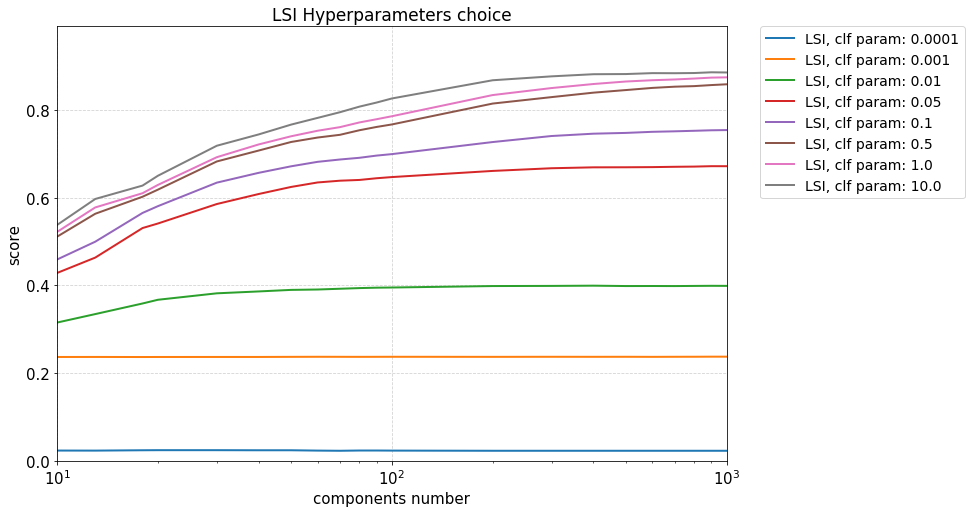

In [65]:
plot_cv_averages_lsi(components_list, svd_averages, range(8), penalty_params,
                 average_index=0, metric_index=2,
                 title='LSI Hyperparameters choice', semilogx=True, xlims=(10, 1000), ylims=(0., 0.99))

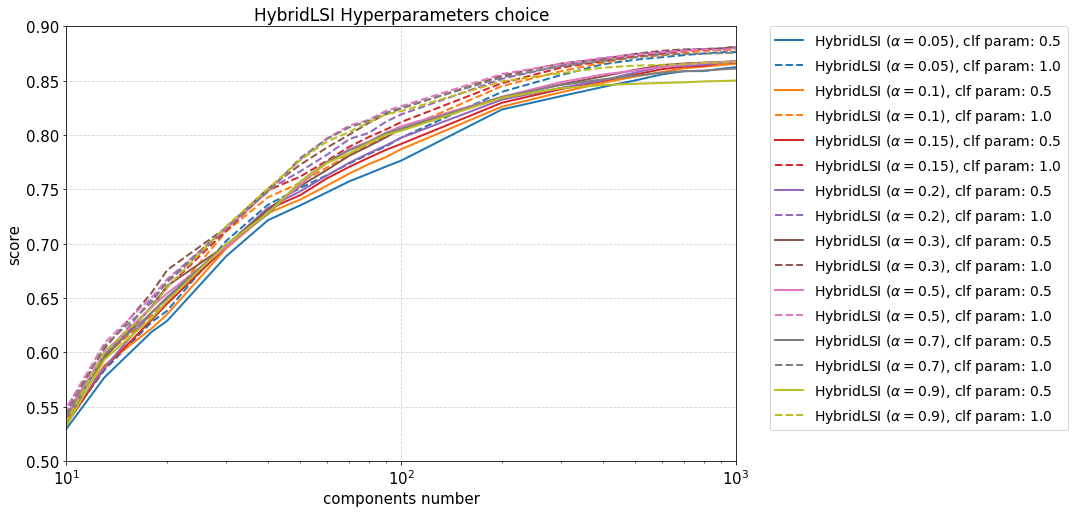

In [74]:
plot_cv_averages(components_list, hsvd_averages, alphas_str, [5, 6], penalty_params,
                 average_index=0, metric_index=2,
                 title='HybridLSI Hyperparameters choice', semilogx=True, xlims=(10, 1000), ylims=(0.5, 0.9))

In [76]:
def find_components_all_params_hsvd(hsvd_averages, components_list, average_index=0, metric_index=2):
    all_values_comps = [{} for k in range(len(components_list))]
    #all_params = [{} for k in range(len(components_list))]
    
    all_values_alphas = [{} for k in range(len(hsvd_averages[0]))]
    
    for k in range(len(components_list)):
        for alpha_num, alpha in enumerate(sorted(hsvd_averages[0].keys())):
            for clf_index, clf_value in enumerate(hsvd_averages[0][alpha]):
                all_values_comps[k][(float(alpha), clf_index)] = clf_value[average_index][metric_index][k]
                all_values_alphas[alpha_num][(k, clf_index)] = clf_value[average_index][metric_index][k]
                
    return all_values_comps, all_values_alphas


def find_components_best_params_hsvd(hsvd_averages, components_list, average_index=0, metric_index=2):
    all_values_comps = [{} for k in range(len(components_list))]
    #all_params = [{} for k in range(len(components_list))]
    
    best_values_alpha = [[] for _ in range(len(components_list))]
    
    for k in range(len(components_list)):
        for alpha_num, alpha in enumerate(sorted(hsvd_averages[0].keys())):
            best_clf = None
            best_score = -np.inf
            for clf_index, clf_value in enumerate(hsvd_averages[0][alpha]):
                score = clf_value[average_index][metric_index][k]
                all_values_comps[k][(float(alpha), clf_index)] = score
                if score > best_score:
                    best_score = score
                    best_clf = clf_index
            best_values_alpha[k].append((best_score, (alpha, best_clf)))
                
                
    best_values = []
    for k in range(len(components_list)):
        best_key = None
        best_score = -np.inf
        for k, v in all_values_comps[k].items():
            if v > best_score:
                best_score = v
                best_key = k
        best_values.append((best_score, best_key))
    return best_values, best_values_alpha



def find_components_all_params_svd(svd_averages, components_list, average_index=0, metric_index=2):
    all_values_comps = [[] for k in range(len(components_list))]        
    for k in range(len(components_list)):
        for clf_index, clf_value in enumerate(svd_averages[0]):
            all_values_comps[k].append(clf_value[average_index][metric_index][k])                
    return all_values_comps


def find_components_best_params_svd(svd_averages, components_list, average_index=0, metric_index=2):
    all_values_comps = find_components_all_params_svd(svd_averages, components_list, average_index, metric_index)
    best_values = []
    for k in range(len(components_list)):
        best_key = None
        best_score = -np.inf
        for k, v in enumerate(all_values_comps[k]):
            if v > best_score:
                best_score = v
                best_key = k
        best_values.append((best_score, best_key))
    return best_values


def find_components_all_params_full_dim(full_dim_averages, average_index=0, metric_index=2):
    all_values_comps = []   
    for clf_index, clf_value in enumerate(full_dim_averages[0]):
        all_values_comps.append(clf_value[average_index][metric_index])                
    return all_values_comps


def find_components_best_params_full_dim(full_dim_averages, average_index=0, metric_index=2):
    all_values_comps = find_components_all_params_full_dim(full_dim_averages, average_index, metric_index)
    best_index = np.argmax(all_values_comps)
    best_score = max(all_values_comps)
    return best_score, best_index

In [77]:
all_values_comps_full = find_components_all_params_full_dim(baseline_averages, average_index=0, metric_index=2)
best_values_comps_full = find_components_best_params_full_dim(baseline_averages, average_index=0, metric_index=2)

In [78]:
all_values_comps_svd = find_components_all_params_svd(svd_averages, components_list, average_index=0, metric_index=2)
best_values_svd = find_components_best_params_svd(svd_averages, components_list, average_index=0, metric_index=2)

In [79]:
all_values_comps, all_values_alphas = find_components_all_params_hsvd(hsvd_averages, components_list,
                                                                       average_index=0, metric_index=2)
best_values, best_values_alpha = find_components_best_params_hsvd(hsvd_averages, components_list,
                                                average_index=0, metric_index=2)

In [86]:
best_values_alpha_top = [sorted(x, key=lambda x: x[0])[-10:][::-1] for x in best_values_alpha]

In [88]:
def plot_component_heatmap(value_component, alphas, penalty_params,
                           title='', figsize=(10, 10)):
    """value_component - dict: keys - tuple(alpha, clf_index)"""
    plt.figure(figsize=figsize)
    alphas_indices = np.arange(len(alphas))
    penalty_params_indices = np.arange(len(penalty_params))
    zs = [value_component[key] for key in sorted(value_component.keys())]
    zs = np.array(zs).reshape(len(alphas_indices), len(penalty_params_indices))
    zs = np.hstack([zs, np.zeros((zs.shape[0], 1))])
    zs = np.vstack([zs, np.zeros((1, zs.shape[1]))])
    xs = list(penalty_params_indices)
    xs.append(penalty_params_indices[-1] + 1)
    ys = list(alphas_indices)
    ys.append(alphas_indices[-1] + 1)
    
    plt.pcolormesh(xs, ys, zs)
    plt.colorbar()
    plt.title(title, size=15)
    plt.xlabel('clf params', size=15)
    plt.ylabel('$\\alpha$', size=15)

    x_ticks = np.array(penalty_params_indices) + 0.5
    labels_x = [str(x) for x in penalty_params]
    plt.xticks(x_ticks, labels_x)
    y_ticks = np.array(alphas_indices) + 0.5
    labels_y = [str(x) for x in alphas]
    plt.yticks(y_ticks, labels_y)
    plt.show()
    
    
def plot_component_heatmap_alphas(value_alpha, components_list, penalty_params, 
                                  title='', figsize=(10, 10)):
    """value_component - dict: keys - tuple(alpha, clf_index)"""
    plt.figure(figsize=figsize)
    components_list_indices = np.arange(len(components_list))
    penalty_params_indices = np.arange(len(penalty_params))
    zs = [value_alpha[key] for key in sorted(value_alpha.keys())]
    zs = np.array(zs).reshape(len(components_list_indices), len(penalty_params_indices))
    zs = np.hstack([zs, np.zeros((zs.shape[0], 1))])
    zs = np.vstack([zs, np.zeros((1, zs.shape[1]))])
    xs = list(penalty_params_indices)
    xs.append(penalty_params_indices[-1] + 1)
    ys = list(components_list_indices)
    ys.append(components_list_indices[-1] + 1)
    plt.pcolormesh(xs, ys, zs)
    plt.colorbar()
    plt.title(title, size=15)
    plt.xlabel('clf params', size=15)
    plt.ylabel('components', size=15)
    x_ticks = np.array(penalty_params_indices) + 0.5
    labels_x = [str(x) for x in penalty_params]
    plt.xticks(x_ticks, labels_x)
    y_ticks = np.array(components_list_indices) + 0.5
    labels_y = [str(x) for x in components_list]
    plt.yticks(y_ticks, labels_y)
    
    plt.show()

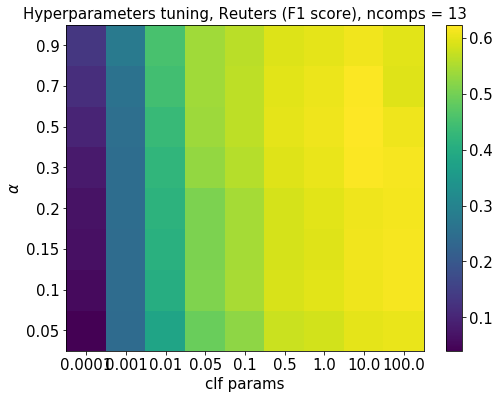

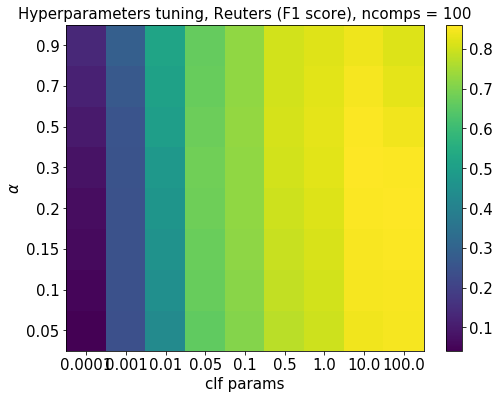

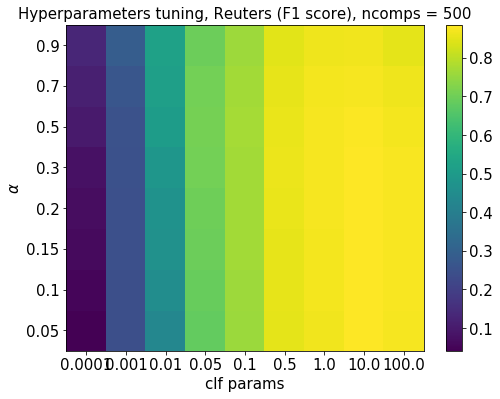

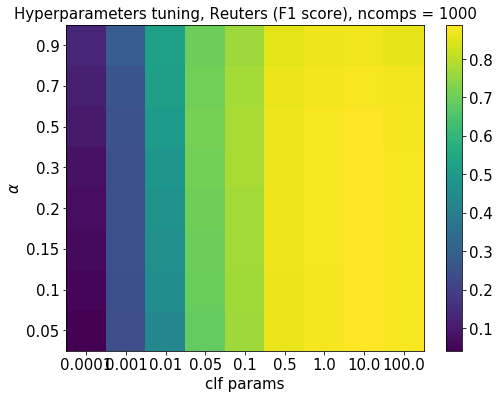

In [92]:
for comps in [13, 100, 500, 1000]:
    plot_component_heatmap(all_values_comps[np.argwhere(components_list == comps)[0, 0]], alphas, 
                           penalty_params,  figsize=(8, 6),
                           title='Hyperparameters tuning, Reuters (F1 score), ncomps = %d' % comps)

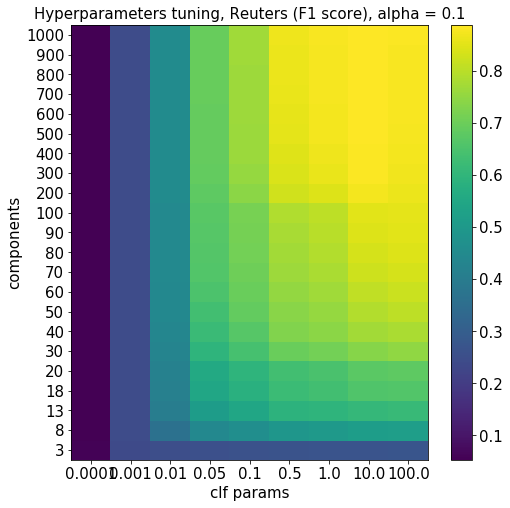

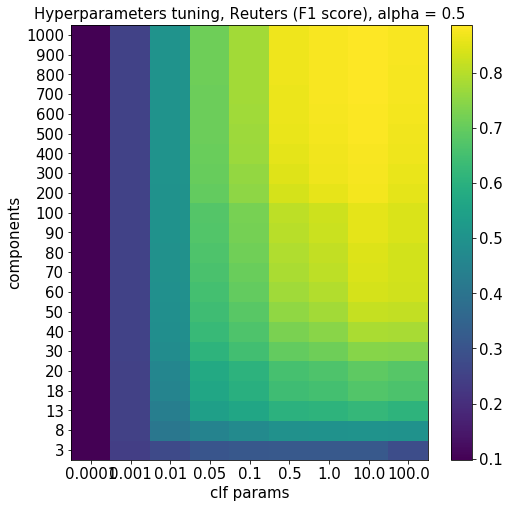

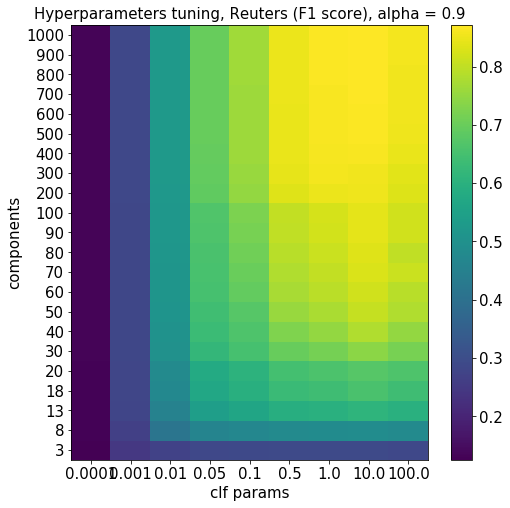

In [93]:
for alpha_index in [1, 5, -1]:
    plot_component_heatmap_alphas(all_values_alphas[alpha_index], components_list, penalty_params, figsize=(8, 8),
                           title='Hyperparameters tuning, Reuters (F1 score), alpha = %s' % str(alphas[alpha_index]))

### classifiers with best parameters

In [117]:
best_clf_full_dim = OneVsRestClassifier(LinearSVC(C=penalty_params[best_values_comps_full[1]], random_state=66))

In [118]:
best_penalty_indices_svd = [x[1] for x in best_values_svd]
penalty_params_per_components_svd = [penalty_params[penalty_index] for penalty_index in best_penalty_indices_svd]
clfs_per_components_svd = [OneVsRestClassifier(LinearSVC(C=C, random_state=66))\
                           for C in penalty_params_per_components_svd]

In [119]:
clfs_per_components_hsvd_dict = {}
for alpha in ['0.1', '0.15', '0.2']:
    best_penalty_indices_hsvd = [y[1][1] for x in best_values_alpha for y in x if y[1][0] == alpha]
    penalty_params_per_components_hsvd = [penalty_params[penalty_index] for penalty_index in best_penalty_indices_hsvd]
    clfs_per_components_hsvd = [OneVsRestClassifier(LinearSVC(C=C, random_state=66)) \
                                for C in penalty_params_per_components_hsvd]
    clfs_per_components_hsvd_dict[alpha] = clfs_per_components_hsvd

In [97]:
[y[1][1] for x in best_values_alpha for y in x if y[1][0] == '0.1']

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7]

In [99]:
[y[1][1] for x in best_values_alpha for y in x if y[1][0] == '0.15']

[8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7]

In [100]:
[y[1][1] for x in best_values_alpha for y in x if y[1][0] == '0.2']

[8, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7]

In [107]:
[y[1][1] for x in best_values_alpha for y in x if y[1][0] == '0.9']

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7]

In [108]:
def check_hybrid_SVD_best(X_train, X_test, y_train, y_test, S, components_list, 
                       clfs, alpha, folding_in_flag=True, str_adding=''):
    predictions = []
    max_components = max(components_list)
    term_hsvd = TermHSVD(float(alpha))
    print(str_adding + 'fitting Hybrid SVD')
    if folding_in_flag:
        term_hsvd.fit(X_train, S, max_components)
        U_train, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
        U_test_Sigma = term_hsvd.transform(X_test, max_components)
    else:
        X = scipy.sparse.vstack([X_train, X_test])
        term_hsvd.fit(X, S, max_components)
        U, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    print(str_adding + 'fitting Hybrid SVD ended')
    U_train_Sigma = U_train @ Sigma
    for n_comps, clf in zip(components_list, clfs):
        print(str_adding + 'n_comps: %d' % n_comps)
        U_train_Sigma_cut = U_train_Sigma[:,:n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        print(str_adding + 'fitting classifier')
        clf.fit(U_train_Sigma_cut, y_train)
        predictions.append(clf.predict(U_test_Sigma_cut))
        print(str_adding + 'ended')
    print()
    return predictions


def check_ordinary_SVD_best(X_train, X_test, y_train, y_test, components_list, 
                       clfs, folding_in_flag=True, str_adding=''):
    predictions = []
    max_components = max(components_list)
    print(str_adding + 'fitting SVD')
    if folding_in_flag:
        U_train, Sigma, VT = tr_svd(X_train,  max_components)
        U_test_Sigma = X_test @ VT.T
    else:
        X = scipy.sparse.vstack([X_train.toarray(), X_test.toarray()])
        U, Sigma, VT = tr_svd(X,  max_components)
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    U_train_Sigma = U_train @ Sigma
    print(str_adding + 'fitting SVD ended')
    for n_comps, clf in zip(components_list, clfs):
        print(str_adding + 'n_comps: %d' % n_comps)
        U_train_Sigma_cut = U_train_Sigma[:,:n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        print(str_adding + 'fitting classifier')
        clf.fit(U_train_Sigma_cut, y_train)
        predictions.append(clf.predict(U_test_Sigma_cut))
        print(str_adding + 'ended')
    print()
    return predictions



def fit_predict_best(X_train, X_test, y_train, y_test, vocabulary, S, components_list,
                   alphas, best_clfs, folding_in_flag=True):
    metrics_names = ['weighted', 'micro', 'macro']
    
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                    vocabulary=vocabulary)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    data = (X_train_tfidf, X_test_tfidf, y_train, y_test)
    #baseline
    print('baseline method:')
    best_clfs[0].fit(X_train_tfidf, y_train)
    baseline_prediction = best_clfs[0].predict(X_test_tfidf)
    print('ended')
    metrics_baseline = []
    for metrics_name in metrics_names:
        metric_result = compute_metrics_baseline(y_test, baseline_prediction, metrics_name)
        metrics_baseline.append(metric_result)

    #svd
    svd_predictions = check_ordinary_SVD_best(*data, components_list, best_clfs[1], folding_in_flag)
    metrics_svd = []
    for metrics_name in metrics_names:
        metric_result = compute_metrics(y_test, svd_predictions, metrics_name)
        metrics_svd.append(metric_result)

    #hsvd
    hsvd_predictions_alphas = Parallel(n_jobs=3)(delayed(check_hybrid_SVD_best)(*data, S, components_list, 
                                best_clfs[2][alpha], alpha, folding_in_flag, '(%s)' % str(alpha)) for alpha in alphas)
    
    results_hsvd = {}
    for alpha, hsvd_predictions in zip(alphas, hsvd_predictions_alphas):
        metrics_hsvd = []
        for metrics_name in metrics_names:
            metric_result = compute_metrics(y_test, hsvd_predictions, metrics_name)
            metrics_hsvd.append(metric_result)
        results_hsvd[alpha] = metrics_hsvd
    
    return (metrics_baseline, metrics_svd, results_hsvd)

In [121]:
best_clfs = [best_clf_full_dim, clfs_per_components_svd, clfs_per_components_hsvd_dict]

In [122]:
alphas_to_train_best = list(best_clfs[2].keys())

In [ ]:
results_best = fit_predict_best(data_new['x_train'], data_new['x_test'], data_new['y_train'],  data_new['y_test'], 
                                vocabulary, S, components_list, alphas_to_train_best, best_clfs, 
                                folding_in_flag=True)

baseline method:
ended
fitting SVD


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting SVD ended
n_comps: 3
fitting classifier
ended
n_comps: 8
fitting classifier
ended
n_comps: 13
fitting classifier
ended
n_comps: 18
fitting classifier
ended
n_comps: 20
fitting classifier
ended
n_comps: 30
fitting classifier
ended
n_comps: 40
fitting classifier
ended
n_comps: 50
fitting classifier
ended
n_comps: 60
fitting classifier
ended
n_comps: 70
fitting classifier
ended
n_comps: 80
fitting classifier
ended
n_comps: 90
fitting classifier
ended
n_comps: 100
fitting classifier
ended
n_comps: 200
fitting classifier
ended
n_comps: 300
fitting classifier
ended
n_comps: 400
fitting classifier
ended
n_comps: 500
fitting classifier
ended
n_comps: 600
fitting classifier
ended
n_comps: 700
fitting classifier
ended
n_comps: 800
fitting classifier
ended
n_comps: 900
fitting classifier
ended
n_comps: 1000
fitting classifier
ended



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.1)fitting Hybrid SVD
(0.15)fitting Hybrid SVD
(0.2)fitting Hybrid SVD


In [124]:
len(results_best)

3

#### Save

In [125]:
with open('saved_files/reuters_best_results', 'w') as f:
    json.dump(results_best, f)

#### Load

In [ ]:
with open('saved_files/reuters_best_results') as f:
    results_best = json.load(f)

In [129]:
def plot_results_final(x, results_first, alphas_to_plot, average_num=0, i=0,
                 title='', figsize=(10, 10), save_path=None, xlims=None, ylims=None, semilogx=False):
    methods = ['baseline', 'svd', 'hsvd']
    colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    averages_names = ['Weighted-averaged F1', 'Micro-averaged F1', 'Macro-averaged F1']
    plt.figure(figsize=figsize)
    #i = 2 # f1
    lw = 2
    # baseline
    plt.hlines(results_first[0][average_num][i], x[0], x[-1], 
               label='Full-dimensional', lw=3, color='tab:brown', linestyle=':')
    #svd
    if not semilogx:
        plt.plot(x, results_first[1][average_num][i], lw=lw, ls='--',
             label='LSI', c='tab:green')
    else:
        plt.semilogx(x, results_first[1][average_num][i], lw=lw,  ls='--',
             label='LSI', c='tab:green')
    #hsvd
    for alpha_num, alpha in enumerate(alphas_to_plot):
        if not semilogx:
            plt.plot(x, results_first[2][alpha][average_num][i], lw=lw,
             label='HybridLSI $\\alpha = %s$' % str(alpha), c=colors[alpha_num])
        else:
            plt.semilogx(x, results_first[2][alpha][average_num][i], lw=lw,
             label='HybridLSI $\\alpha = %s$' % str(alpha), c=colors[alpha_num])
        
    plt.xlabel('Number of components', size=17)
    plt.ylabel(averages_names[average_num], size=17)
    if semilogx:
        x_ticks = [10, 100, 1000]
        labels = ['$10^1$', '$10^2$', '$10^3$']
        plt.xticks(x_ticks, labels)
    
    if xlims is not None:
        plt.xlim(*xlims)
    if ylims is not None:
        plt.ylim(*ylims)
    
    plt.title(title, size=22)
    plt.legend(prop={'size': 14}, loc="lower right")
    plt.grid(color='lightgray', linestyle='dashed')
    
    
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [130]:
alphas_to_plot = ['0.1', '0.15', '0.2']

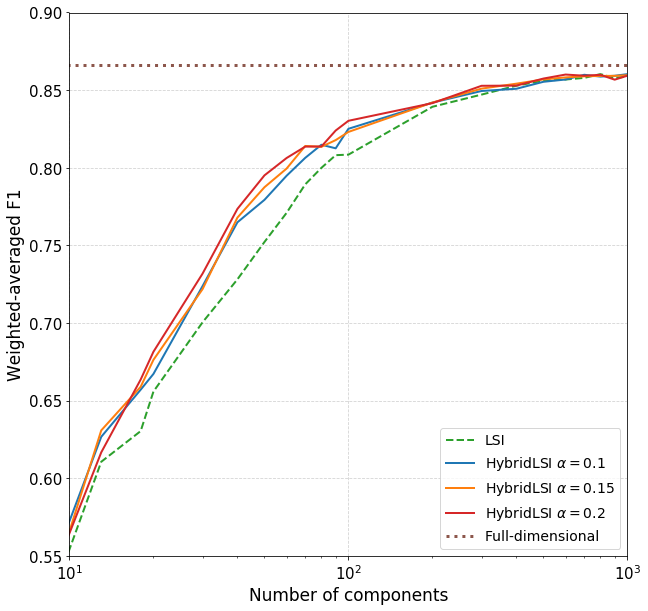

In [144]:
plot_results_final(components_list, results_best, alphas_to_plot, average_num=0, i=2,
                   ylims=(0.55, 0.9), xlims=(10, 1000), semilogx=True, figsize=(10, 10))

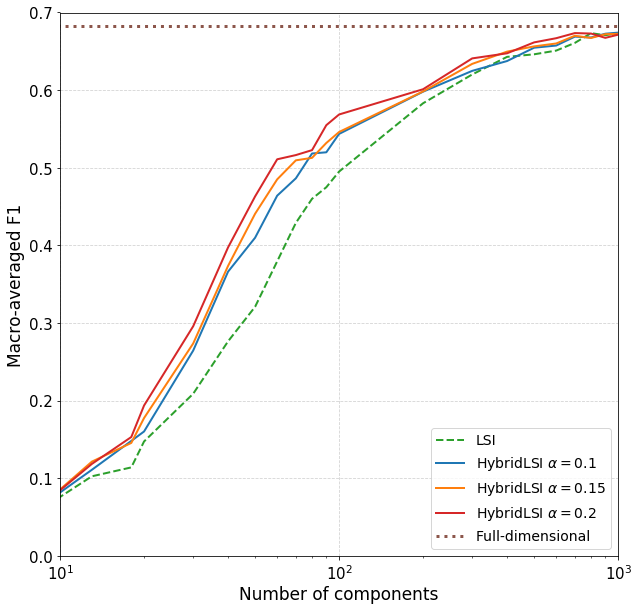

In [143]:
plot_results_final(components_list, results_best, alphas_to_plot, average_num=2, i=2,
                   ylims=(0., 0.7), xlims=(10, 1000), semilogx=True, figsize=(10, 10))

### with Local

In [188]:
def plot_results_final_with_local(x, results_first, alphas_to_plot, 
                            x_local, saved_scores_rds, saved_scores_weighted, average_num=0, 
                            title='', figsize=(10, 10), save_path=None, xlims=None, ylims=None, semilogx=False):
    methods = ['baseline', 'svd', 'hsvd']
    colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    averages_names = ['Weighted-averaged F1', 'Micro-averaged F1', 'Macro-averaged F1']
    plt.figure(figsize=figsize)
    i = 2 # f1
    lw = 3
    # baseline
    plt.hlines(results_first[0][average_num][i], x[0], x[-1], 
               label='Full-dimensional', lw=3, color='tab:brown', linestyle=':')
    #svd
    if not semilogx:
        plt.plot(x, results_first[1][average_num][i], lw=lw, ls='--',
             label='LSI', c='tab:green')
    else:
        plt.semilogx(x, results_first[1][average_num][i], lw=lw,  ls='--',
             label='LSI', c='tab:green')
    #hsvd
    for alpha_num, alpha in enumerate(alphas_to_plot):
        if not semilogx:
            plt.plot(x, results_first[2][alpha][average_num][i], lw=lw,
             label='HybridLSI $\\alpha = %s$' % str(alpha), c=colors[alpha_num])
        else:
            plt.semilogx(x, results_first[2][alpha][average_num][i], lw=lw,
             label='HybridLSI $\\alpha = %s$' % str(alpha), c=colors[alpha_num])
          
    metric_index = 0 # F1
    #local
    plt.plot(x_local, saved_scores_rds[metric_index], label='LocalLSI', c='tab:olive', lw=lw)
    
    #LRW
    plt.plot(x_local, saved_scores_weighted[metric_index], label='LRW-LSI', c='tab:cyan', lw=lw)
        
    plt.xlabel('Number of components', size=17)
    plt.ylabel(averages_names[average_num], size=17)
    if semilogx:
        x_ticks = [10, 100, 1000]
        labels = ['$10^1$', '$10^2$', '$10^3$']
        plt.xticks(x_ticks, labels)
    
    if xlims is not None:
        plt.xlim(*xlims)
    if ylims is not None:
        plt.ylim(*ylims)
    
    plt.title(title, size=22)
    plt.legend(prop={'size': 14}, loc="lower right")
    plt.grid(color='lightgray', linestyle='dashed')
    
    
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [200]:
#saved_rds = np.load('local_lsi_reuters/Reuters_saved_scores_RDS.npy')
saved_scores_rds = np.load('local_lsi_reuters/Reuters_saved_scores_RDS.npy')
#saved_weighted = np.load('Local_LSI/saved_Weighted.npy')
saved_scores_weighted = np.load('local_lsi_reuters/Reuters_saved_scores_Weighted.npy')

In [201]:
components_list_final = [3, 8, 13, 20, 50, 100, 200, 300, 500, 700, 1000]

In [202]:
len(components_list_final)

11

In [203]:
saved_scores_rds.shape

(4, 11)

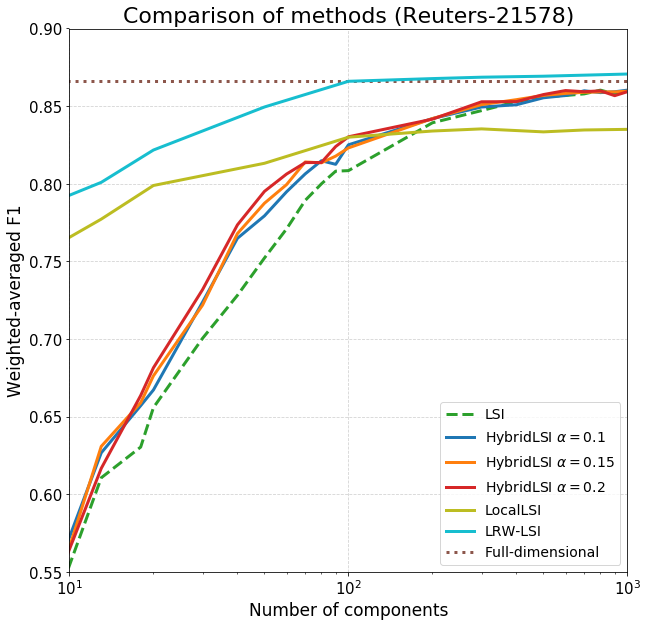

In [204]:
plot_results_final_with_local(components_list, results_best, alphas_to_plot, 
                   components_list_final, saved_scores_rds, saved_scores_weighted, average_num=0, 
                   ylims=(0.55, 0.9), xlims=(10, 1000), semilogx=True, figsize=(10, 10),
                    title='Comparison of methods (Reuters-21578)')

In [206]:
plot_results_final_with_local(components_list, results_best, alphas_to_plot, 
                   components_list_final, saved_scores_rds, saved_scores_weighted, average_num=0, 
                   ylims=(0.55, 0.9), xlims=(10, 1000), semilogx=True, figsize=(10, 10),
                    title='Comparison of methods (Reuters-21578)',
                    save_path="/root/hlsi/saved_files/reuters_final_comparison")